In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pprint
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import string
from collections import Counter
import csv
import datetime
import plotnine
from plotnine import *
import plotly.express as px
from plotly import graph_objs as go
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [33]:
post_covid = pd.read_csv('postcovid_reviews.csv')
pre_covid = pd.read_csv('precovid_reviews.csv')

In [34]:
pre_covid['Pre_covid'] = True
post_covid['Pre_covid'] = False
colnames = list(pre_covid)

In [35]:
reviews = pre_covid.merge(post_covid,on=colnames, how='outer')
reviews = reviews[reviews['is_open'] == True] 
#reviews.columns

In [11]:
reviews.describe()

,latitude,longitude,stars,review_count,is_open,customer_stars,useful,funny,cool
count,4302877.000,4302877.000,4302877.000,4302877.000,4302877.000,4302877.000,4302877.000,4302877.000,4302877.000
mean,38.135,-92.499,3.794,562.688,1.000,3.793,0.945,0.366,0.475
std,6.998,19.353,0.583,879.243,0.000,1.361,2.654,1.730,2.161
min,28.063,-123.350,1.000,5.000,1.000,1.000,0.000,0.000,0.000
25%,30.316,-105.278,3.500,136.000,1.000,3.000,0.000,0.000,0.000
50%,40.064,-84.367,4.000,308.000,1.000,4.000,0.000,0.000,0.000
75%,42.551,-81.255,4.000,631.000,1.000,5.000,1.000,0.000,0.000
max,49.460,71.113,5.000,9185.000,1.000,5.000,446.000,529.000,530.000


In [81]:
reviews[['Date', 'Time']]= reviews['date_'].str.split(" +",expand = True)
reviews[['Year', 'Month', 'Day']] = reviews['Date'].str.split("-",expand = True)
reviews.drop(['date_', 'Date'],axis=1,inplace=True)

In [82]:
cnt = reviews.groupby('Year').size().rename('Count')
dates = reviews.drop_duplicates(subset='Year').merge(cnt, left_on='Year', right_index=True)
dates['Year'] = pd.to_numeric(dates['Year'])
dates = dates[~(dates['Year'] == 2021)]

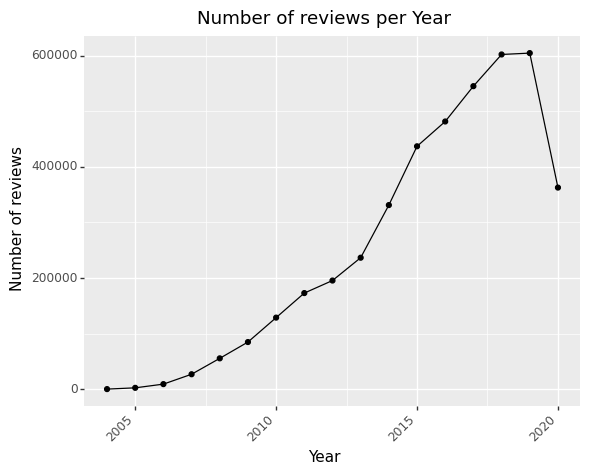

<ggplot: (8781788352979)>

In [87]:
(   ggplot(dates)  # plots data
    + aes(x="Year", y="Count", group=1)  
    + geom_point()
    + geom_line()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + plotnine.labels.ylab('Number of reviews')
     + plotnine.labels.ggtitle('Number of reviews per Year')

)

In [8]:
num_of_restaurants = len(reviews['business_id'].unique())
num_of_restaurants

32022

# Plot

In [9]:
def plot_stuff(data, x, y, ytickmin, ytickmax, xlabel, ylabel, title, png):
    plt.figure(figsize=(8,4))
    ax = sns.barplot(data=data,x=x, y=y)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
    ax.set_ylim([ytickmin, ytickmax])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(png, bbox_inches='tight')
    plt.show()

### States with most restaurants

In [12]:
reviews['state_'] = np.where(reviews['state_'] == 'ABE', 'BC', reviews['state_'])
reviews['state_'] = np.where(reviews['state_'] == 'WA', 'OR', reviews['state_'])


In [13]:
reviews = reviews.loc[reviews['state_'].isin(['GA', 'BC', 'TX', 'MA', 'OR', 'FL', 'OH', 'CO'])]
reviews['state_'].unique()

array(['GA', 'BC', 'TX', 'MA', 'OR', 'FL', 'OH', 'CO'], dtype=object)

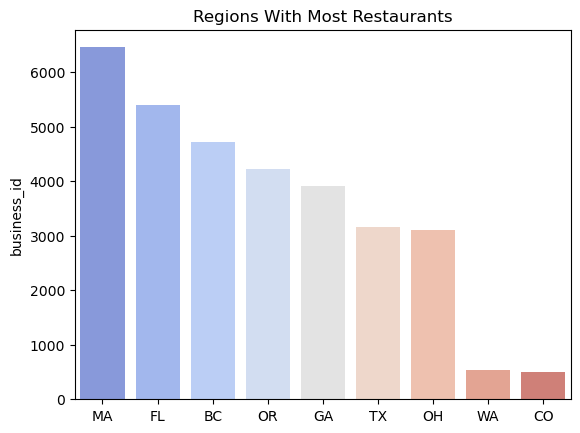

In [114]:
unique_restaraunt_state = reviews.drop_duplicates(['business_id']).groupby('state_')['business_id'].count().reset_index().sort_values('business_id', ascending = False)
unique_restaraunt_state = unique_restaraunt_state[unique_restaraunt_state['business_id'] > 2]
ax = sns.barplot(data=unique_restaraunt_state,x="state_", y="business_id",alpha=0.8, palette = 'coolwarm')

plt.xlabel('')
plt.title("Regions With Most Restaurants")
plt.show()



### Restaurants with most reviews

In [13]:
df = reviews[['name', 'state_', 'review_count','categories']].drop_duplicates()
most_reviewed = df[df['categories'].str.contains('Restaurant.*') ==True]
most_reviewed = most_reviewed.sort_values('review_count', ascending = False).head(10)
most_reviewed

,name,state_,review_count,categories
256598,Voodoo Doughnut - Old Town,OR,9185,"Local Flavor, Food, Donuts, Wedding Chapels, E..."
584796,Mike's Pastry,MA,7298,"Candy Stores, Gelato, Food, Coffee & Tea, Rest..."
171033,Screen Door,OR,7219,"Caterers, Restaurants, Breakfast & Brunch, Sou..."
725451,Neptune Oyster,MA,5115,"Arabian, Thai, American (Traditional), Live/Ra..."
162412,Franklin Barbecue,TX,4942,"Local Flavor, Salad, Sandwiches, Restaurants, ..."
73418,Moonshine Patio Bar & Grill,TX,4833,"Venues & Event Spaces, American (Traditional),..."
11,Hopdoddy Burger Bar,TX,4708,"American (New), American (Traditional), Restau..."
501586,The Salt Lick BBQ,TX,4524,"Food, Wineries, Restaurants, Arts & Entertainm..."
575134,Mother’s Bistro & Bar,OR,4466,"American (Traditional), Restaurants, Bars, Nig..."
96200,Powell's City of Books,OR,4295,"Food, Airports, Bookstores, Flowers & Gifts, C..."


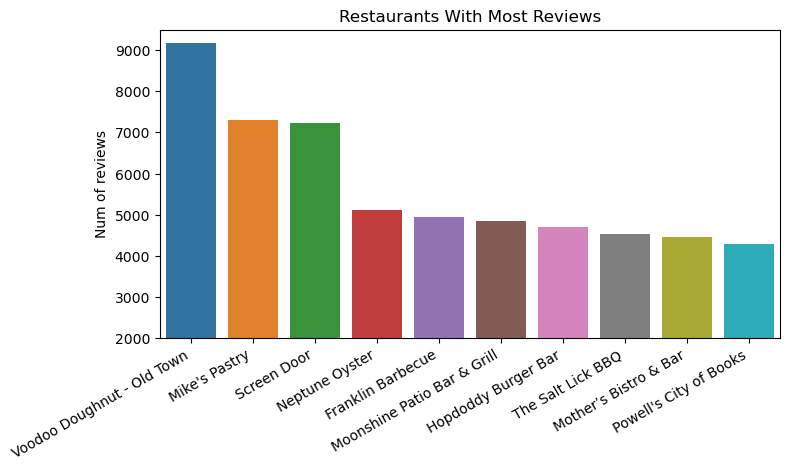

In [14]:
plot_stuff(most_reviewed, 'name', 'review_count', 2000, 9500, None, 'Num of reviews', 'Restaurants With Most Reviews', 'most_reviews.png')


## Most popular restaurants with atleast 500 reviews

In [115]:
most_popular = reviews[['name', 'state_','review_count', 'customer_stars']]
popularity = most_popular.groupby('name', as_index=False).agg({'review_count':'max', 'customer_stars':'mean', 'state_':'max'})
most_popular = popularity[popularity['review_count'] >= 500].sort_values('customer_stars', ascending = False).head(12)

most_popular



,name,review_count,customer_stars,state_
9468,Jewboy Burgers,516,4.856,TX
1183,Aviva by Kameel,1532,4.824,GA
4224,Ciao! Pizza & Pasta,733,4.816,MA
21292,Tōv,503,4.801,OR
18573,Swiss Hibiscus,510,4.787,OR
15539,Powell's City of Books,4295,4.770,OR
14234,Ovation Coffee & Tea,740,4.763,OR
37,1618 Asian Fusion,641,4.746,TX
19385,Thai Wok Kitchen,556,4.714,WA
16889,Santorini Cafe,736,4.702,TX


In [116]:
fig = px.bar(most_popular, x='name', y='customer_stars', color = 'state_', title = "The Highest Rated Restaurants")
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.update_layout(yaxis=dict(range=[4,4.9]))
fig.show()

# Least popular restaurants with atleast 500 reviews

In [120]:
least_popular = popularity[popularity['review_count'] >= 500].sort_values('customer_stars', ascending = True).head(12)

fig = px.bar(least_popular, x='name', y='customer_stars', color = 'state_', title = "The Lowest Rated Restaurants")

fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.update_layout(yaxis=dict(range=[1,3]))
fig.show()

## States w best restaurants

In [121]:
best_state = reviews[['state_', 'review_count', 'customer_stars']]
best_state = best_state.groupby('state_', as_index=False).agg({'review_count':'max', 'customer_stars':'mean'})
best_state = best_state[best_state['review_count'] > 28].sort_values('customer_stars', ascending = False).head(12)
best_state    

,state_,review_count,customer_stars
11,OR,9185,3.909
2,CO,1491,3.880
12,TX,4942,3.862
3,FL,3236,3.824
10,OH,1354,3.764
4,GA,3861,3.740
7,MA,7298,3.726
14,WA,719,3.698
1,BC,2302,3.682


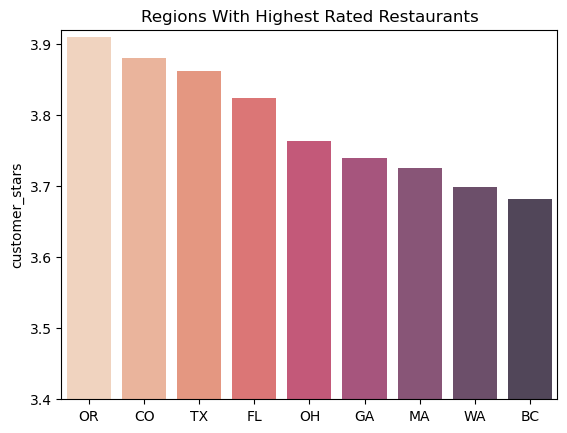

In [122]:
ax = sns.barplot(data=best_state,x="state_", y="customer_stars",alpha=0.8, palette = 'rocket_r')
ax.set_ylim([3.4,3.92])

plt.xlabel('')
plt.title("Regions With Highest Rated Restaurants")
plt.show()


# How does customer sentiment correlate with star ratings

In [27]:
vader = SentimentIntensityAnalyzer()

In [28]:
%%capture --no-display

f = lambda text: vader.polarity_scores(text)['compound']
reviews['compound'] = reviews['text_'].apply(f)

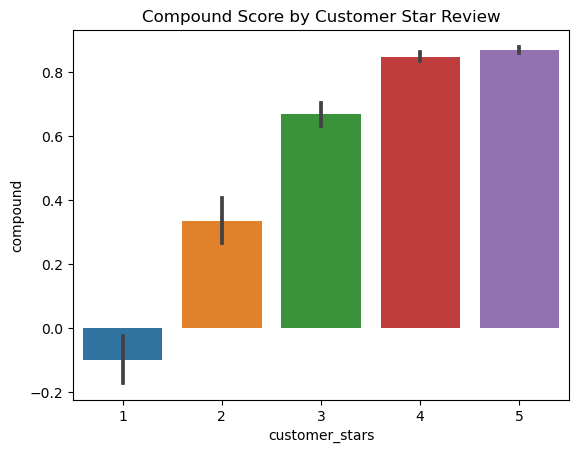

In [29]:
ax = sns.barplot(data=reviews, x='customer_stars', y='compound')
ax.set_title('Compound Score by Customer Star Review')
plt.savefig('Compound_Score_by_Customer.png', bbox_inches='tight')
plt.show()

# What words appear the most in positive/negative reviews?


In [124]:
positive_reviews = reviews[reviews['customer_stars'] >= 4]
negative_reviews = reviews[reviews['customer_stars'] <= 2]
negative_subset.head(2)

,business_id,name,address,state_,city,postal_code,latitude,longitude,stars,review_count,...,hours,review_id,user_id,customer_stars,useful,funny,cool,text_,date_,Pre_covid
1,TA1KUSCu8GkWP9w0rmElxw,FLIP burger boutique,1587 Howell Mill Rd,GA,Atlanta,30318,33.798,-84.416,4.000,1909,...,"{'Monday': '12:0-20:0', 'Tuesday': '12:0-20:0'...",Gi5LSRmTXoL9Bp4jNGPjLw,hn0ZbitvmlHnF--KJGJ6_A,4,0,0,0,I have been here twice and have had really goo...,2011-10-27 14:32:57,True
3,mOnesB4IF9j6-ZmHoOHOig,Pho Van,8557 Research Blvd,TX,Austin,78758,30.361,-97.716,4.000,364,...,"{'Monday': '10:30-21:0', 'Tuesday': '10:30-21:...",GDgXjXSZCA1iNQWD7OHXfg,1RCRKuHgP3FskGUVnmFdxg,4,0,0,0,I think their rice dishes are way better than ...,2017-05-26 03:05:46,True
4,jMz_y_-cWMfiZF7Q5snE6Q,Ramen Danbo,1333 Robson Street,BC,Vancouver,V6E 2B1,49.287,-123.129,4.500,436,...,"{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",1OsubwE6zKNU1fkBGxOFrQ,vFnYYmtVwcMGyyGesNImVQ,5,0,0,0,Ordered the original tonkotsu base ramen and a...,2016-01-30 02:39:22,True
5,tiKV9b0b2kpaGm5a-nd1ig,Ristorante Serena,18 Lebanon St,MA,Malden,02148,42.434,-71.046,4.500,119,...,"{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",g2xwd2o7ynGmdxhoDctooQ,QpsbLV8dNFI9cxhrBGA0Rw,4,0,0,0,This place is truly a hidden gem (literally hi...,2015-01-03 21:34:06,True
6,luOZQ9YBrWwP8mYrS4rNoA,Happy Fortune,10420 SW Barbur Blvd,OR,Portland,97219,45.450,-122.727,3.000,71,...,"{'Monday': '11:30-22:0', 'Tuesday': '11:30-22:...",nJTSr-EGNhhA5o146THkPg,T9O5pkKKlNvr-qqfefDlbA,4,2,0,0,This place has some of the BEST chinese take-o...,2008-12-03 04:39:26,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63293,T1r8VNuEWlsmmHCER4nnUA,The Megabite,10411 NE Fourth Plain Blvd,WA,Vancouver,98662,45.662,-122.565,4.000,98,...,"{'Monday': '11:0-22:0', 'Wednesday': '11:0-21:...",CLJcvwrQ7j4EECqEv0E8hA,MNKqJzdYzh3WfhozcuKXfQ,4,4,2,2,Found this place by accident...was shopping fo...,2018-07-06 03:53:30,True
63297,KK-6rXbIo9B4-b_P5WO5Qg,Clay Pit,1601 Guadalupe St,TX,Austin,78701,30.279,-97.742,4.000,1583,...,"{'Monday': '16:0-21:0', 'Tuesday': '11:0-21:0'...",9Wh7mMI6FROK7wLH9jXpsQ,2oVYK0HEtNsZvBqAU8DGgg,5,1,0,1,"Great for gluten free, good with kids. Food is...",2014-09-23 20:25:55,True
63298,4UjU7F_EX3lgUtkzN8Bbrw,Shan-A-Punjab,500 Harvard St,MA,Brookline,02446,42.348,-71.130,4.000,426,...,"{'Monday': '11:30-22:0', 'Tuesday': '11:30-22:...",BzGX9hYGN29EvldW_TZmCw,NjbNbvysh1Y0j_KIHVebOg,5,0,0,0,Only have a few minutes - but stopped by a wee...,2015-04-27 21:15:59,True
63300,bZiIIUcpgxh8mpKMDhdqbA,Hopdoddy Burger Bar,"1400 S Congress Ave, Ste A190",TX,Austin,78704,30.250,-97.750,4.000,4708,...,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",3mOzfG1IgVmSMCwOtkgu7w,qtnLyAYMcONRbqAD-aQEiA,5,0,0,0,This has remained my favorite sit down burger ...,2014-07-25 21:43:59,True


In [125]:
gist_file = open("stopwords.txt", "r")
try:
    content = gist_file.read()
    stopwords = content.split(",")
    stopwords=[i.replace('"',"").strip() for i in stopwords]
finally:
    gist_file.close()
len(stopwords)

1160

In [126]:
def common_words(df, column, punctuations, stop_words):
    check = " ".join(df[column].tolist())
    check = check.replace('\r', '').replace('\n', '')
    
    filtered_sentence = []
    words = word_tokenize(check)
    
    for w in words:
        if w.lower() not in stop_words:
            filtered_sentence.append(w)
            
    filtered_sentence = [i for i in filtered_sentence if (i not in punctuations) and (len(i)>2)]
    filtered_sentence = [w for w in filtered_sentence if all(c not in w for c in "''")]
    common = Counter(filtered_sentence).most_common(30)
    return(common)

In [127]:
punctuations = list(string.punctuation)
punctuations.append("''")
punctuations.append('..')
punctuations.append("``")
punctuations.append('...')
punctuations.append('--')

In [42]:
positive_reviews = common_words(positive_reviews, 'text_', punctuations, stopwords)
negative_reviews = common_words(negative_reviews, 'text_', punctuations, stopwords)

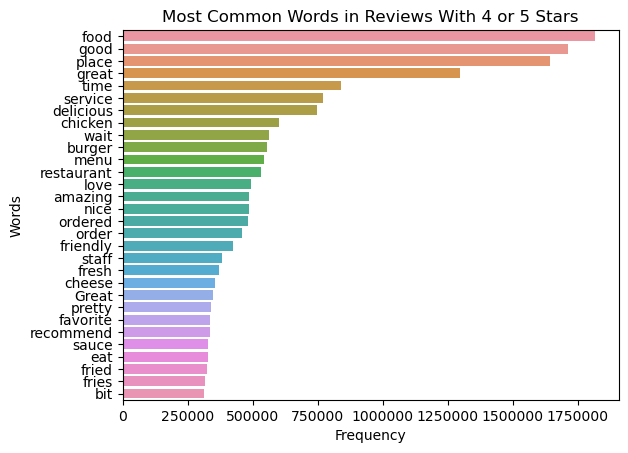

In [59]:
x_positive = [x for x,y in positive_reviews]
y_positive = [y for x,y in positive_reviews]
ax = sns.barplot(x=l, y=x_positive)
ax.set_title('Most Common Words in Reviews With 4 or 5 Stars')
ax.set_xlabel('Frequency')
ax.set_ylabel('Words')

plt.ticklabel_format(style='plain', axis='x')


plt.show()

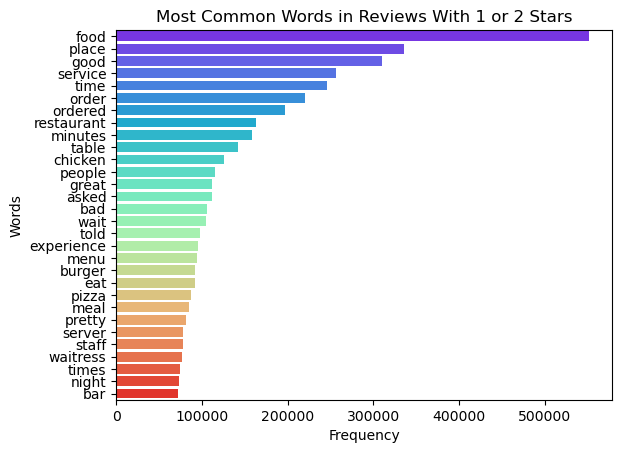

In [103]:
x_negative = [x for x,y in negative_reviews] 
y_negative = [y for x,y in negative_reviews] 
ax = sns.barplot(x=l, y=x_negative, palette = 'rainbow')
ax.set_title('Most Common Words in Reviews With 1 or 2 Stars')
ax.set_xlabel('Frequency')
ax.set_ylabel('Words')
#plt.savefig('unpopular_words.png', bbox_inches='tight')

plt.show()

In [104]:
x_negative

['food',
 'place',
 'good',
 'service',
 'time',
 'order',
 'ordered',
 'restaurant',
 'minutes',
 'table',
 'chicken',
 'people',
 'great',
 'asked',
 'bad',
 'wait',
 'told',
 'experience',
 'menu',
 'burger',
 'eat',
 'pizza',
 'meal',
 'pretty',
 'server',
 'staff',
 'waitress',
 'times',
 'night',
 'bar']

In [105]:
x_positive

['food',
 'good',
 'place',
 'great',
 'time',
 'service',
 'delicious',
 'chicken',
 'wait',
 'burger',
 'menu',
 'restaurant',
 'love',
 'amazing',
 'nice',
 'ordered',
 'order',
 'friendly',
 'staff',
 'fresh',
 'cheese',
 'Great',
 'pretty',
 'favorite',
 'recommend',
 'sauce',
 'eat',
 'fried',
 'fries',
 'bit']

In [113]:
[(w, x_negative.count(w)) for w in set(x_negative) if w not in x_positive]

[('asked', 1),
 ('told', 1),
 ('experience', 1),
 ('server', 1),
 ('bad', 1),
 ('people', 1),
 ('meal', 1),
 ('pizza', 1),
 ('table', 1),
 ('times', 1),
 ('minutes', 1),
 ('bar', 1),
 ('night', 1),
 ('waitress', 1)]

In [108]:
[(w, x_positive.count(w)) for w in set(x_positive) if w in x_negative]

[('eat', 1),
 ('good', 1),
 ('ordered', 1),
 ('menu', 1),
 ('service', 1),
 ('great', 1),
 ('wait', 1),
 ('order', 1),
 ('time', 1),
 ('chicken', 1),
 ('pretty', 1),
 ('food', 1),
 ('staff', 1),
 ('restaurant', 1),
 ('place', 1),
 ('burger', 1)]